In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

## Data Overview

In [3]:
filepath = 'Data/resa_girasole_2022.gpkg'

# Read the .gpkg file
gdf = gpd.read_file(filepath)

print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1962 entries, 0 to 1961
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Data/Ora    1962 non-null   object  
 1   Longitudin  1962 non-null   object  
 2   Latitudine  1962 non-null   object  
 3   RESAKG      1962 non-null   float64 
 4   VELOCITA    1962 non-null   float64 
 5   AREA        1962 non-null   float64 
 6   UMIDITA     1925 non-null   float64 
 7   geometry    1962 non-null   geometry
dtypes: float64(4), geometry(1), object(3)
memory usage: 122.8+ KB
None


In [5]:
print(gdf.head(5))

               Data/Ora  Longitudin  Latitudine  RESAKG  VELOCITA     AREA  \
0  5 set 2022, 10:08:09  11,9758245  44,8474908  1870.0      4.80  140.000   
1  5 set 2022, 10:08:24  11,9758157  44,8476751  1270.0      4.83  140.875   
2  5 set 2022, 10:08:40  11,9758154  44,8478795  1420.0      4.78  139.417   
3  5 set 2022, 10:08:55  11,9758209  44,8480593  2010.0      4.85  141.458   
4  5 set 2022, 10:09:10  11,9758201  44,8482443  1320.0      4.80  140.000   

   UMIDITA                         geometry  
0      NaN  POINT (1333142.685 5597543.903)  
1      NaN  POINT (1333141.706 5597572.841)  
2      NaN  POINT (1333141.672 5597604.934)  
3     33.1  POINT (1333142.284 5597633.165)  
4     33.1  POINT (1333142.195 5597662.213)  


This dataset contains geospatial observations with timestamps, longitude, latitude, speed, area, and humidity. The 'geometry' column provides spatial coordinates for mapping.

In [6]:
# Check the coordinate reference system (CRS)
print(gdf.crs)

EPSG:3857


In [8]:
# Change the CRS from EPSG:3857 to EPSG:4326
gdf_4326 = gdf.to_crs(epsg=4326)  # Convert the geometry to EPSG:4326

print(gdf_4326[['Longitudin', 'Latitudine', 'geometry']].head(5))

   Longitudin  Latitudine                   geometry
0  11,9758245  44,8474908  POINT (11.97582 44.84749)
1  11,9758157  44,8476751  POINT (11.97582 44.84768)
2  11,9758154  44,8478795  POINT (11.97582 44.84788)
3  11,9758209  44,8480593  POINT (11.97582 44.84806)
4  11,9758201  44,8482443  POINT (11.97582 44.84824)


As we can see, the coordinates of the file are in EPSG:3857, whereas the coordinates saved in the 'Longitudin' and 'Latitudine' columns are string characters of coordinates in EPSG:4326.

In [9]:
# Summary statistics
print(gdf.describe())

            RESAKG     VELOCITA         AREA      UMIDITA
count  1962.000000  1962.000000  1962.000000  1925.000000
mean   2255.285423     4.903976   143.032629    27.022805
std     699.827651     0.614924    17.935293     6.154021
min      50.000000     0.780000    22.750000    18.600000
25%    1792.500000     4.570000   133.292000    22.200000
50%    2300.000000     4.900000   142.917000    25.800000
75%    2730.000000     5.180000   151.083000    30.200000
max    4880.000000    10.910000   318.208000    50.100000


Let's check for duplicates or null values in the dataset.

In [10]:
# Check for duplicated rows
print(gdf.duplicated().sum())

0


In [11]:
# Check for missing values
print(gdf.isnull().sum())

Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       37
geometry       0
dtype: int64


There are no duplicated rows and there are 37 missing values in the 'UMIDITA' column. We are going to deal with them later.

## Data Visualization

Let's start analysing the distributions of the variables and their relationships.

In [15]:
# Calculate the correlation matrix
numeric_columns = gdf.select_dtypes(include=[np.number]).columns
correlation_matrix = gdf[numeric_columns].corr()

# Display the correlation matrix
print(correlation_matrix)

            RESAKG  VELOCITA      AREA   UMIDITA
RESAKG    1.000000 -0.374292 -0.374292 -0.172451
VELOCITA -0.374292  1.000000  1.000000 -0.149498
AREA     -0.374292  1.000000  1.000000 -0.149497
UMIDITA  -0.172451 -0.149498 -0.149497  1.000000


<Figure size 1200x1000 with 0 Axes>

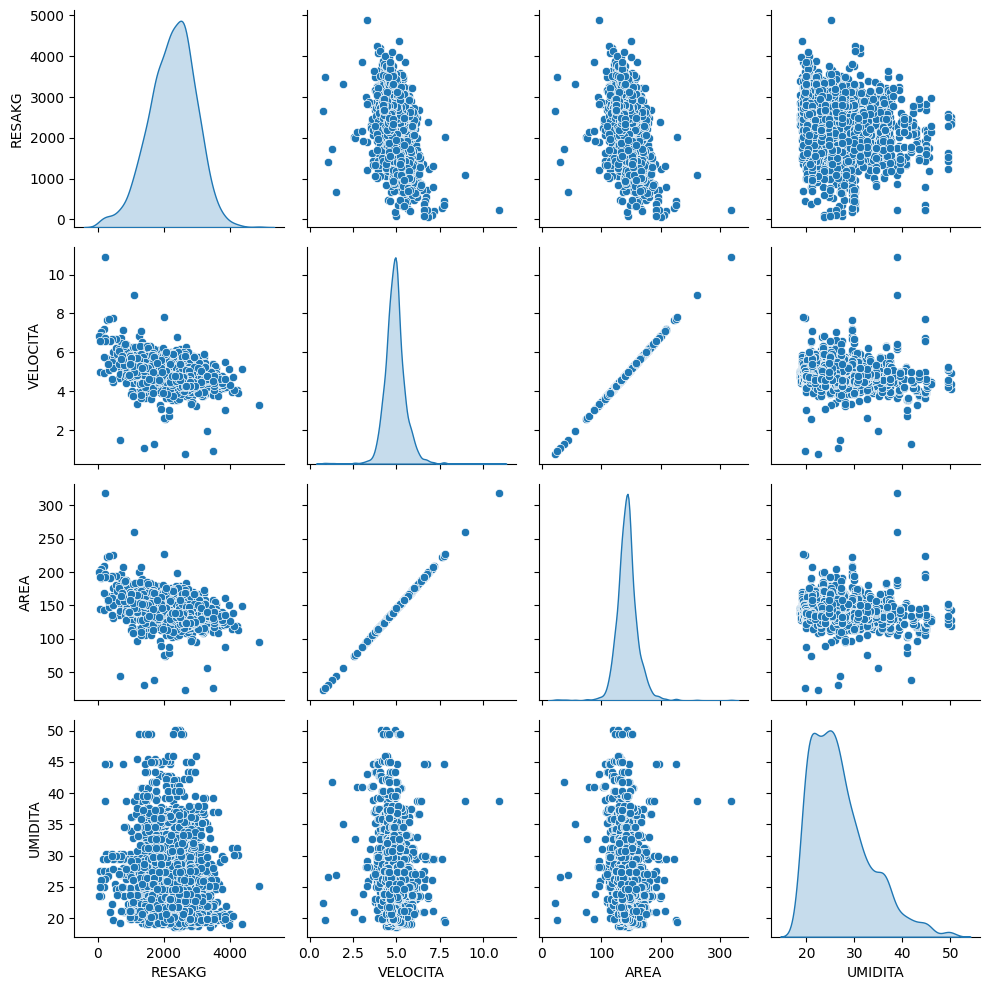

In [16]:
# Select only the numeric columns
numeric_columns = ['RESAKG', 'VELOCITA', 'AREA', 'UMIDITA']

# Create the pairplot
plt.figure(figsize=(12, 10))
sns.pairplot(gdf[numeric_columns], diag_kind='kde')
plt.tight_layout()
plt.show()

As we can clearly see from the correlation matrix and the pairplot, the variables VELOCITA and AREA are linearly dependent. The other variables seem not to have some linear relationship between them.

Actually, we found that AREA is calculated with this formula:
AREA = 15 / (60*60) * VELOCITA * 7. The unit od measure of AREA is the m2 - squared meter. 15 seconds is the time interval between 2 consecutive observations (the default one), 7 m is the width of the harvest machine.

This detail is very important because the value of AREA is strictly dependent on the VELOCITA (which is the recorded speed of the machine). The speed of the harvest machine is a variable that can vary and also oscillate greatly due to acceleration, deceleration, and steering.

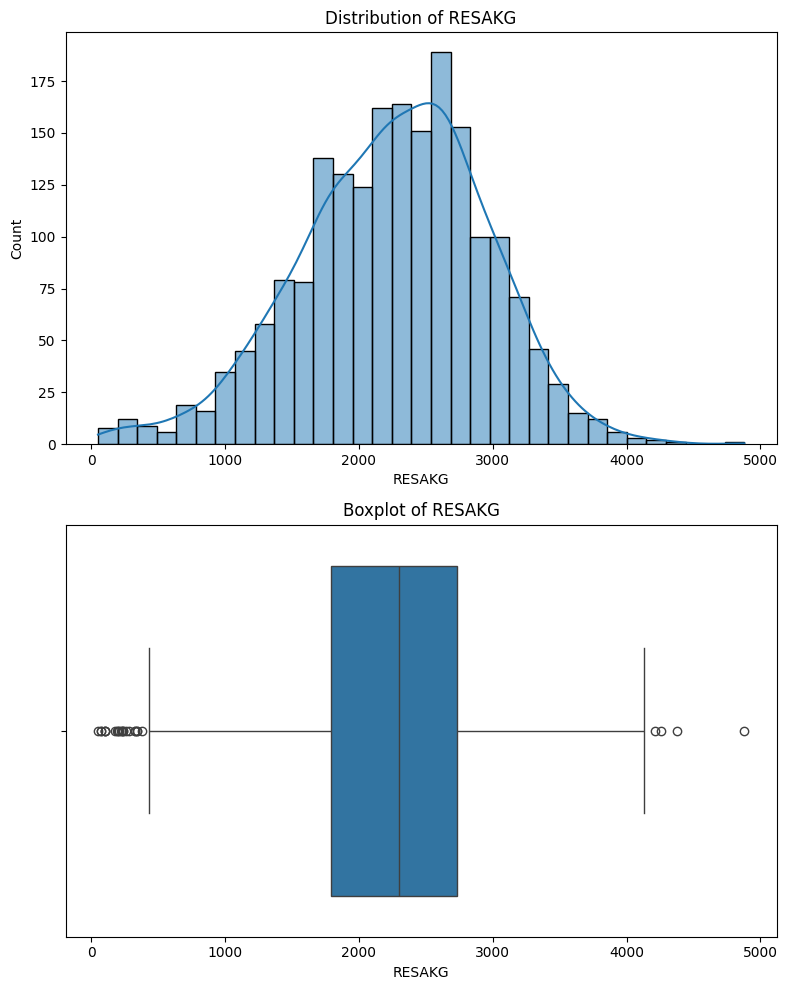

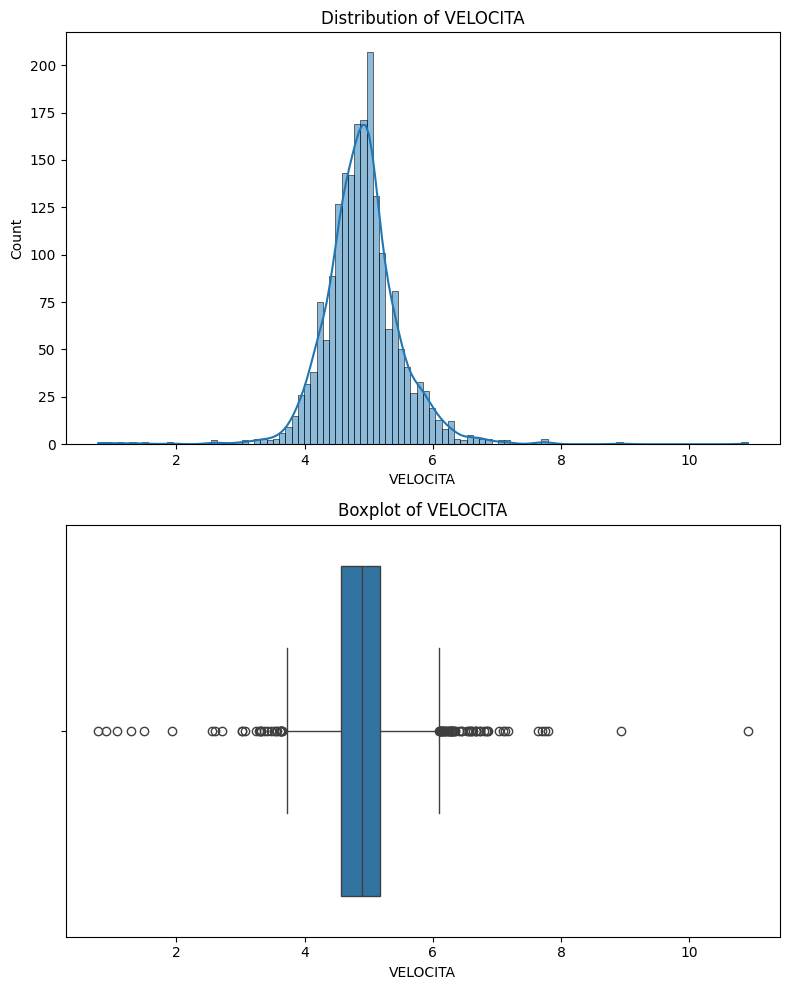

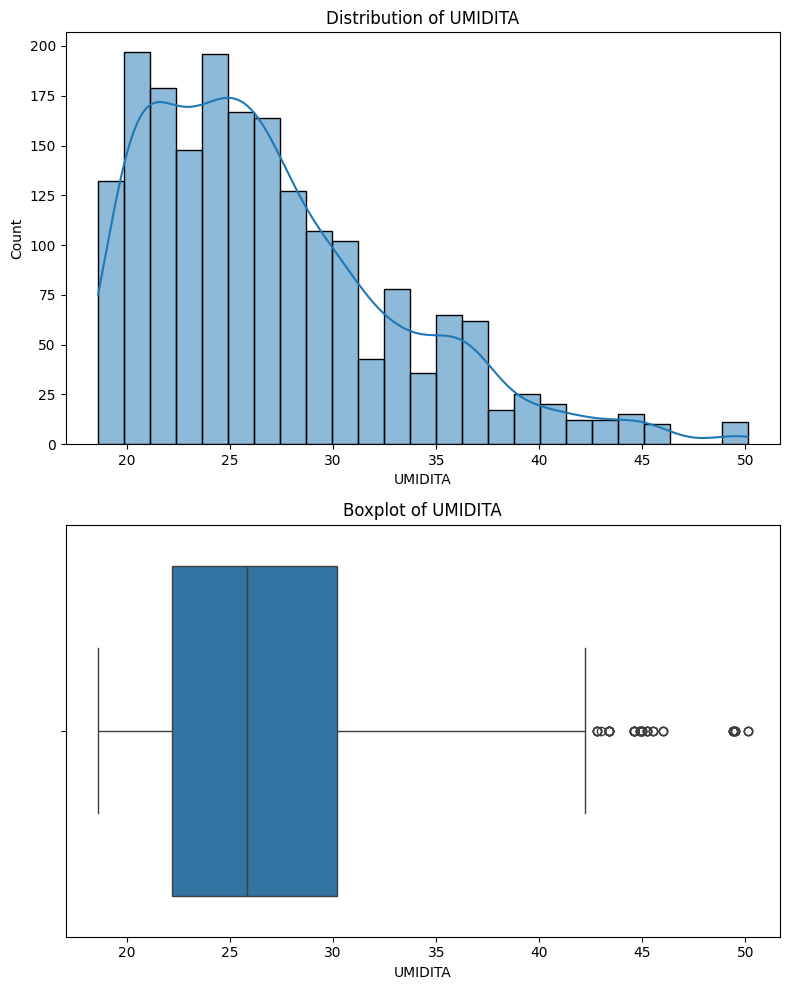

In [17]:
# Distribution plots and boxplots for specific numerical columns
specific_columns = ['RESAKG', 'VELOCITA', 'UMIDITA']
for column in specific_columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
    
    # Histogram
    sns.histplot(gdf[column], kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column}')
    
    # Boxplot
    sns.boxplot(x=gdf[column], ax=ax2)
    ax2.set_title(f'Boxplot of {column}')
    
    plt.tight_layout()
    plt.show()

We can see that the variables RESAKG and VELOCITA are centred variables, whereas UMIDITA is a right-skewed variable. As we were expecting, VELOCITA has many outliers that we should address.

## Time Analysis

Our dataset contains a column with timestamps. Now we are going to analyse them and the relationship of time with the other variables.

Dates and times are in Italian format, so we need to set the local time to Italian.

In [18]:
import locale

# Set locale to Italian
locale.setlocale(locale.LC_TIME, 'it_IT.UTF-8')
# Convert 'Data/Ora' to datetime
gdf['Data/Ora'] = pd.to_datetime(gdf['Data/Ora'], format='%d %b %Y, %H:%M:%S')

In [19]:
# Calculate the difference between the first and last elements
first_date = gdf['Data/Ora'].iloc[0]
last_date = gdf['Data/Ora'].iloc[-1]
difference_first_last = last_date - first_date

# Calculate the difference between the most recent and oldest dates
most_recent = gdf['Data/Ora'].max()
oldest = gdf['Data/Ora'].min()
difference_recent_oldest = most_recent - oldest

# Output the differences
print(f"Difference between first and last: {difference_first_last}")
print(f"Difference between most recent and oldest: {difference_recent_oldest}")

Difference between first and last: -2 days +10:05:56
Difference between most recent and oldest: 4 days 19:56:50


Our dataset is not originally ordered by time, which is something we must address. At the same time, the data is related to one single year, so we will not deal with cyclic patterns across different years.

In [20]:
# Sort the dataframe by date in place
gdf.sort_values('Data/Ora', inplace=True)
print(f"Difference between first and last: {gdf['Data/Ora'].iloc[-1] - gdf['Data/Ora'].iloc[0]}")

Difference between first and last: 4 days 19:56:50


Now that the dataset is properly sorted by time, we will create two new columns: one representing the difference in time between two consecutive observations, the other representing the difference in speed between two consecutive observations. These 2 variables will be useful later.

In [21]:
# Calculate time differences between consecutive readings. Current - previous
gdf['Time_Diff'] = gdf['Data/Ora'].diff().dt.total_seconds()

# Calculate speed differences between consecutive readings
gdf['Speed_Diff'] = gdf['VELOCITA'].diff()

## Data Cleaning

Before cleaning the dataset, we needed to address the time issue. Now, let's deal with the missing values.

In [22]:
# First, let's check the pattern of NaN values
nan_mask = gdf['UMIDITA'].isna()
gdf[nan_mask].sort_values('Data/Ora')

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry,Time_Diff,Speed_Diff
507,2022-09-03 10:07:15,"11,9658697","44,8508319",2000.0,4.53,132.125,NaN,POINT (1332034.522 5598068.512),231971.0,-0.36
508,2022-09-03 10:07:30,"11,9658738","44,8506627",3410.0,4.41,128.625,NaN,POINT (1332034.978 5598041.944),15.0,-0.12
772,2022-09-03 13:21:06,"11,9671421","44,8504851",900.0,6.03,175.875,NaN,POINT (1332176.165 5598014.057),1581.0,-0.81
773,2022-09-03 13:21:21,"11,9671458","44,8502495",1200.0,5.98,174.417,NaN,POINT (1332176.577 5597977.063),15.0,-0.05
774,2022-09-03 13:21:37,"11,9671498","44,8499923",1310.0,6.30,183.750,NaN,POINT (1332177.022 5597936.678),16.0,0.32
894,2022-09-03 14:03:49,"11,9679801","44,8502976",2660.0,5.17,150.792,NaN,POINT (1332269.451 5597984.616),307.0,1.19
1060,2022-09-03 14:59:05,"11,9691475","44,8487801",3490.0,4.16,121.333,NaN,POINT (1332399.405 5597746.341),16.0,0.87
1061,2022-09-03 14:59:20,"11,9691416","44,8486175",3260.0,4.45,129.792,NaN,POINT (1332398.748 5597720.81),15.0,0.29
1062,2022-09-03 14:59:36,"11,9691469","44,8484191",2400.0,5.04,147.000,NaN,POINT (1332399.338 5597689.659),16.0,0.59
1063,2022-09-03 14:59:51,"11,969148","44,8482271",2250.0,5.04,147.000,NaN,POINT (1332399.461 5597659.512),15.0,0.00


What we can notice is that NaN values in UMIDITA are not randomly distributed. They tend to appear in clusters, and most of the time we can check that the value in 'Time_Diff' column is far from the 15 seconds default value. This means that the machine was just started in that moment and perhaps the sensors may take some time to record the values. Indeed most of the time, NaN values last only few consecutive observations.

There is an interval, tough, from index 1060 to 1082, where the NaN values are not due to the machine just starting but maybe to some other issues in recording the moisture data. The value of UMIDITA will be very relevant in the following analysis, so we will fill these NaN that are not consecutive to a stop of the machine with the last value available. We are assuming that the value of moisture is not changing much as long as the machine keeps moving and recording. Instead, when the machine starts from a dead stop, we will assume that those values can be cancelled. 

In [23]:
gdf.loc[1059]

Data/Ora                            2022-09-03 14:58:49
Longitudin                                   11,9691458
Latitudine                                   44,8489432
RESAKG                                           4880.0
VELOCITA                                           3.29
AREA                                             95.958
UMIDITA                                            25.2
geometry      POINT (1332399.215686449 5597771.9504774)
Time_Diff                                          15.0
Speed_Diff                                        -1.47
Name: 1059, dtype: object

In [24]:
gdf.loc[1060:1082, 'UMIDITA'] = 25.2

In [25]:
print(gdf.isna().sum())

Data/Ora       0
Longitudin     0
Latitudine     0
RESAKG         0
VELOCITA       0
AREA           0
UMIDITA       14
geometry       0
Time_Diff      1
Speed_Diff     1
dtype: int64


The NaN values have been reduced now, and we can proceed with dropping those rows.

In [26]:
gdf.dropna(inplace=True)
gdf.reset_index(drop=True, inplace=True)

## Data Recalibration

The data regarding the yield of the harvest are stored in the column 'RESAKG'. This variable represents the weight of the sunflower (seeds) harvested for this particular field. The unit of measure is kg. In order to map the yield across the field, we need to recalibrate that variable to account both for the moisture level recorded and the area harvested.

In [27]:
# Assuming a standard moisture content of 9% for dry sunflower seeds
standard_moisture = 9.0
gdf['Recalibrated_Weight'] = gdf['RESAKG'] * (100 - gdf['UMIDITA']) / (100 - standard_moisture)

# Calculate yield in kg/m²
gdf['Yield_kg_m2'] = gdf['Recalibrated_Weight'] / gdf['AREA']

# Display the first few rows of the updated dataset
print(gdf[['RESAKG', 'UMIDITA', 'AREA', 'Recalibrated_Weight', 'Yield_kg_m2']].head())

# Summary statistics for the new columns
print(gdf[['Recalibrated_Weight', 'Yield_kg_m2']].describe())

   RESAKG  UMIDITA     AREA  Recalibrated_Weight  Yield_kg_m2
0  1240.0     36.8  137.375           861.186813     6.268876
1  2190.0     36.8  137.667          1520.967033    11.048160
2  2260.0     36.8  120.167          1569.582418    13.061676
3  2680.0     25.7  119.292          2188.175824    18.343022
4  2190.0     25.7  113.750          1788.098901    15.719551
       Recalibrated_Weight  Yield_kg_m2
count          1947.000000  1947.000000
mean           1819.332154    13.138950
std             610.104074     5.800009
min              41.978022     0.210416
25%            1392.543956     9.849923
50%            1836.835165    12.898547
75%            2228.571429    16.150769
max            4011.252747   117.655678


The Yield_kg_m2 column is the variable we will use as main variable for the rest of the analysis. the unit of measure is kg/m2. Typically, it is in kg/ha, but we are considering a very granular dataset where the area harvested per observation is small relative to the total area of the field. Hence we will keep the unit of measure as kg/m2.

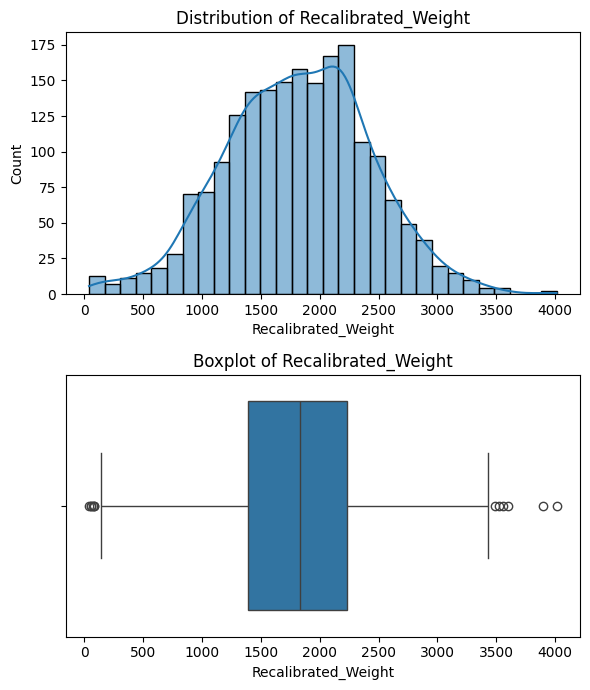

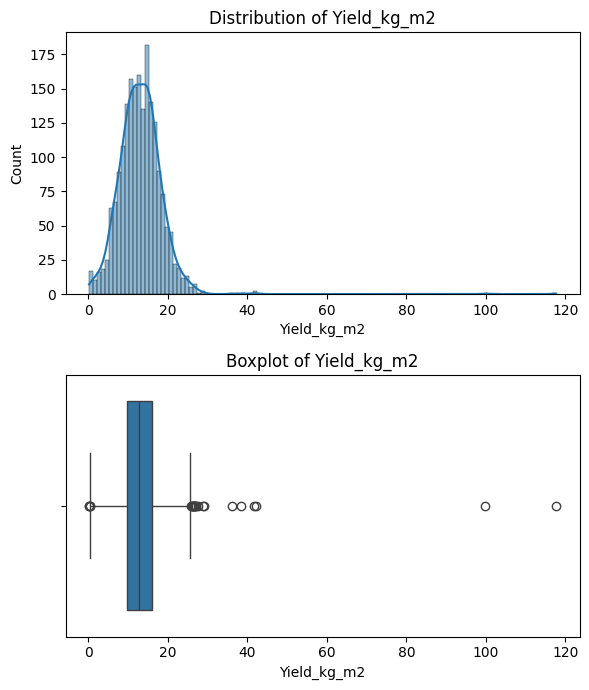

In [33]:
# Distribution plots and boxplots for specific numerical columns
specific_columns = ['Recalibrated_Weight', 'Yield_kg_m2']
for column in specific_columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7))
    
    # Histogram
    sns.histplot(gdf[column], kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column}')

    # Boxplot
    sns.boxplot(x=gdf[column], ax=ax2)
    ax2.set_title(f'Boxplot of {column}')
    
    plt.tight_layout()
    plt.show()

We can clearly see that the variable Yield_kg_m2 has distinct outliers, whereas the variable Recalibrated_Weight seems more regular. This is most likely due to the values of VELOCITA, that can oscillate and affect the AREA calculation, which in turn affects the Yield_kg_m2.

## Analysis of Differences

Let's turn our attention to the variables 'Time_Diff' and 'Speed_Diff'.

In [34]:
print('Distribution of time differences (seconds):')
print(gdf['Time_Diff'].describe())
print('Distribution of speed differences (km/h):')
print(gdf['Speed_Diff'].describe())

Distribution of time differences (seconds):
count    1947.000000
mean       24.012840
std        82.560379
min        15.000000
25%        15.000000
50%        15.000000
75%        16.000000
max      3360.000000
Name: Time_Diff, dtype: float64
Distribution of speed differences (km/h):
count    1947.000000
mean        0.000781
std         0.518345
min        -4.980000
25%        -0.050000
50%         0.010000
75%         0.080000
max         5.530000
Name: Speed_Diff, dtype: float64


As we mentioned, the observations are taken every 15 seconds, but sometimes the machine can stop for some reasons or some values may be missed.

The question we want to answer is the following: the fact that the machine stops for some time or the speed changes drastically, can affect the yield calculation? If so, what are the effects and how can we address them?

### Time Diff Analysis

In [35]:
# Define thresholds
threshold_1 = 45  # value of 3 observations = 15 seconds * 3 = 45 seconds
threshold_2 = 60 * 60 * 1  # 1 hours in seconds

# Count observations above thresholds
count_above_1 = (gdf['Time_Diff'] > threshold_1).sum()
count_above_2 = (gdf['Time_Diff'] > threshold_2).sum()

print(f"Observations with time difference > 1 minute: {count_above_1}")
print(f"Observations with time difference > 1 hours: {count_above_2}")

Observations with time difference > 1 minute: 148
Observations with time difference > 1 hours: 0


In [36]:
# Create a boolean mask for rows with large time differences, excluding the first row
large_gap_mask = (gdf['Time_Diff'] > threshold_1) & (gdf.index > gdf.index[0])
no_gap_mask = (gdf['Time_Diff'] <= threshold_1) & (gdf.index > gdf.index[0])

# Get the indices of rows with large time differences
large_gap_indices = gdf[large_gap_mask].index

# We can either focus only on the rows with large time gaps or add also the previous rows to the analysis.
paired_rows = pd.concat([
    gdf.loc[large_gap_indices - 1],
    gdf.loc[large_gap_indices]
]).sort_index()

print('Statistics of the rows with large time gaps:')
print(gdf[['RESAKG', 'VELOCITA', 'Yield_kg_m2', 'Time_Diff', 'Speed_Diff']].loc[large_gap_indices].describe())

print('Statistics of the rows with no large time gaps:')
print(gdf[['RESAKG', 'VELOCITA', 'Yield_kg_m2', 'Time_Diff', 'Speed_Diff']].loc[no_gap_mask].describe())

Statistics of the rows with large time gaps:
            RESAKG    VELOCITA  Yield_kg_m2    Time_Diff  Speed_Diff
count   148.000000  148.000000   148.000000   148.000000  148.000000
mean   1932.905405    4.709054    12.456951   118.229730   -0.222703
std     777.889394    0.866164     9.427042   283.540663    1.135518
min      70.000000    0.780000     0.300556    46.000000   -4.980000
25%    1510.000000    4.335000     8.653296    46.000000   -0.592500
50%    1920.000000    4.745000    10.997093    46.000000   -0.230000
75%    2460.000000    5.130000    15.311889    92.000000    0.220000
max    3850.000000    7.710000    99.705833  3360.000000    5.530000
Statistics of the rows with no large time gaps:
            RESAKG     VELOCITA  Yield_kg_m2    Time_Diff   Speed_Diff
count  1798.000000  1798.000000  1798.000000  1798.000000  1798.000000
mean   2285.033370     4.917620    13.198909    16.262514     0.018732
std     685.770934     0.586343     5.393651     3.684413     0.425078
mi

By focusing on the interquartile range of the two distributions, there are not huge differences. 

### Speed Diff Analysis

In [44]:
# Define thresholds for speed differences
speed_std = gdf['Speed_Diff'].std()
speed_mean = gdf['Speed_Diff'].mean()
coeff = 3
speed_threshold_positive = speed_mean + coeff * speed_std
speed_threshold_negative = speed_mean - coeff * speed_std

# Count observations above speed thresholds
count_speed_above_positive = (gdf['Speed_Diff'] > speed_threshold_positive).sum()
count_speed_below_negative = (gdf['Speed_Diff'] < speed_threshold_negative).sum()

print(f"\nSpeed difference standard deviation: {speed_std:.2f} km/h")
print(f"Observations with speed difference > +{coeff} std dev ({speed_threshold_positive:.2f} km/h): {count_speed_above_positive}")
print(f"Observations with speed difference < -{coeff} std dev ({speed_threshold_negative:.2f} km/h): {count_speed_below_negative}")


Speed difference standard deviation: 0.52 km/h
Observations with speed difference > +3 std dev (1.56 km/h): 20
Observations with speed difference < -3 std dev (-1.55 km/h): 26


In [45]:
# Create boolean masks for rows with large speed differences, excluding the first row
largePos_speed_diff_mask = ((gdf['Speed_Diff'] > speed_threshold_positive)) & (gdf.index > gdf.index[0])
largeNeg_speed_diff_mask = (gdf['Speed_Diff'] < speed_threshold_negative) & (gdf.index > gdf.index[0])
normal_speed_diff_mask = ((gdf['Speed_Diff'] <= speed_threshold_positive) & 
                          (gdf['Speed_Diff'] >= speed_threshold_negative)) & (gdf.index > gdf.index[0])

# Get the indices of rows with large speed differences
largePos_speed_diff_indices = gdf[largePos_speed_diff_mask].index
largeNeg_speed_diff_indices = gdf[largeNeg_speed_diff_mask].index

# Create a new DataFrame with pairs of rows (current and previous)
pairedPos_rows = pd.concat([
    gdf.loc[largePos_speed_diff_indices - 1],
    gdf.loc[largePos_speed_diff_indices]
]).sort_index()

pairedNeg_rows = pd.concat([
    gdf.loc[largeNeg_speed_diff_indices - 1],
    gdf.loc[largeNeg_speed_diff_indices]
]).sort_index()

print('Statistics of the rows with large positive speed differences:')
print(gdf[['RESAKG', 'VELOCITA', 'Yield_kg_m2', 'Time_Diff', 'Speed_Diff']].loc[largePos_speed_diff_indices].describe())

print('Statistics of the rows with large negative speed differences:')
print(gdf[['RESAKG', 'VELOCITA', 'Yield_kg_m2', 'Time_Diff', 'Speed_Diff']].loc[largeNeg_speed_diff_indices].describe())

print('\nStatistics of the rows with normal speed differences:')
print(gdf[['RESAKG', 'VELOCITA', 'Yield_kg_m2', 'Time_Diff', 'Speed_Diff']].loc[normal_speed_diff_mask].describe())

Statistics of the rows with large positive speed differences:
            RESAKG   VELOCITA  Yield_kg_m2   Time_Diff  Speed_Diff
count    20.000000  20.000000    20.000000   20.000000   20.000000
mean   1214.000000   6.582000     6.336214   56.750000    2.729000
std    1104.938198   1.736877     7.089049   85.872534    0.927248
min      70.000000   4.170000     0.300556   15.000000    1.750000
25%     265.000000   4.775000     0.884843   15.000000    2.115000
50%     905.000000   6.815000     2.876977   16.000000    2.470000
75%    2040.000000   7.657500     8.881441   34.750000    3.322500
max    3780.000000  10.910000    24.646897  307.000000    5.530000
Statistics of the rows with large negative speed differences:
            RESAKG   VELOCITA  Yield_kg_m2   Time_Diff  Speed_Diff
count    26.000000  26.000000    26.000000   26.000000   26.000000
mean   1981.538462   3.756923    23.120200   39.461538   -2.379231
std    1074.387983   1.636823    27.714728   33.174967    0.966064
min  

Here, we can see that the differences in some variable distributions are significant even when we only focus on the interquartile range. This suggests that the variation in the speed of the machine can affect the yield calculation more than the variation in time between consecutive observations.

### Difference Analysis Visualization

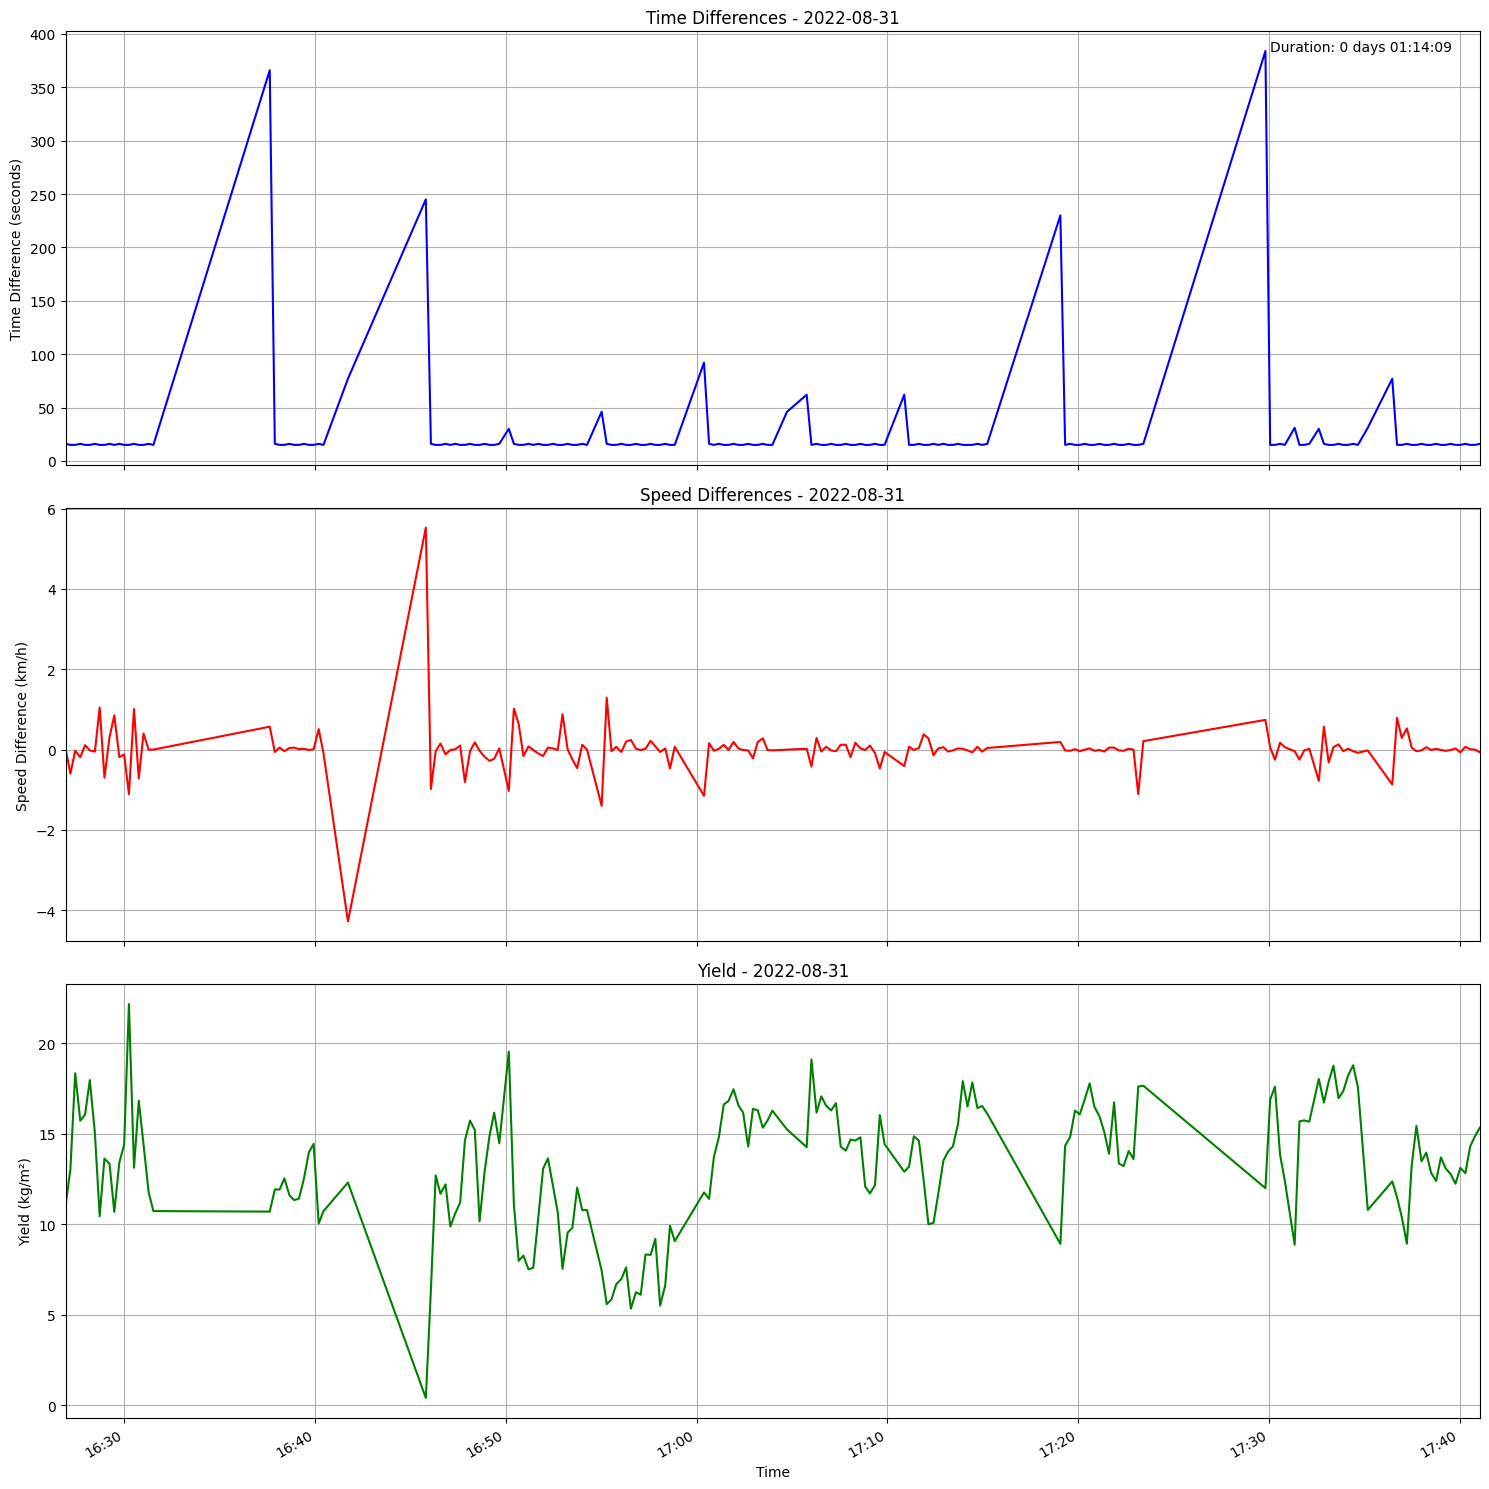

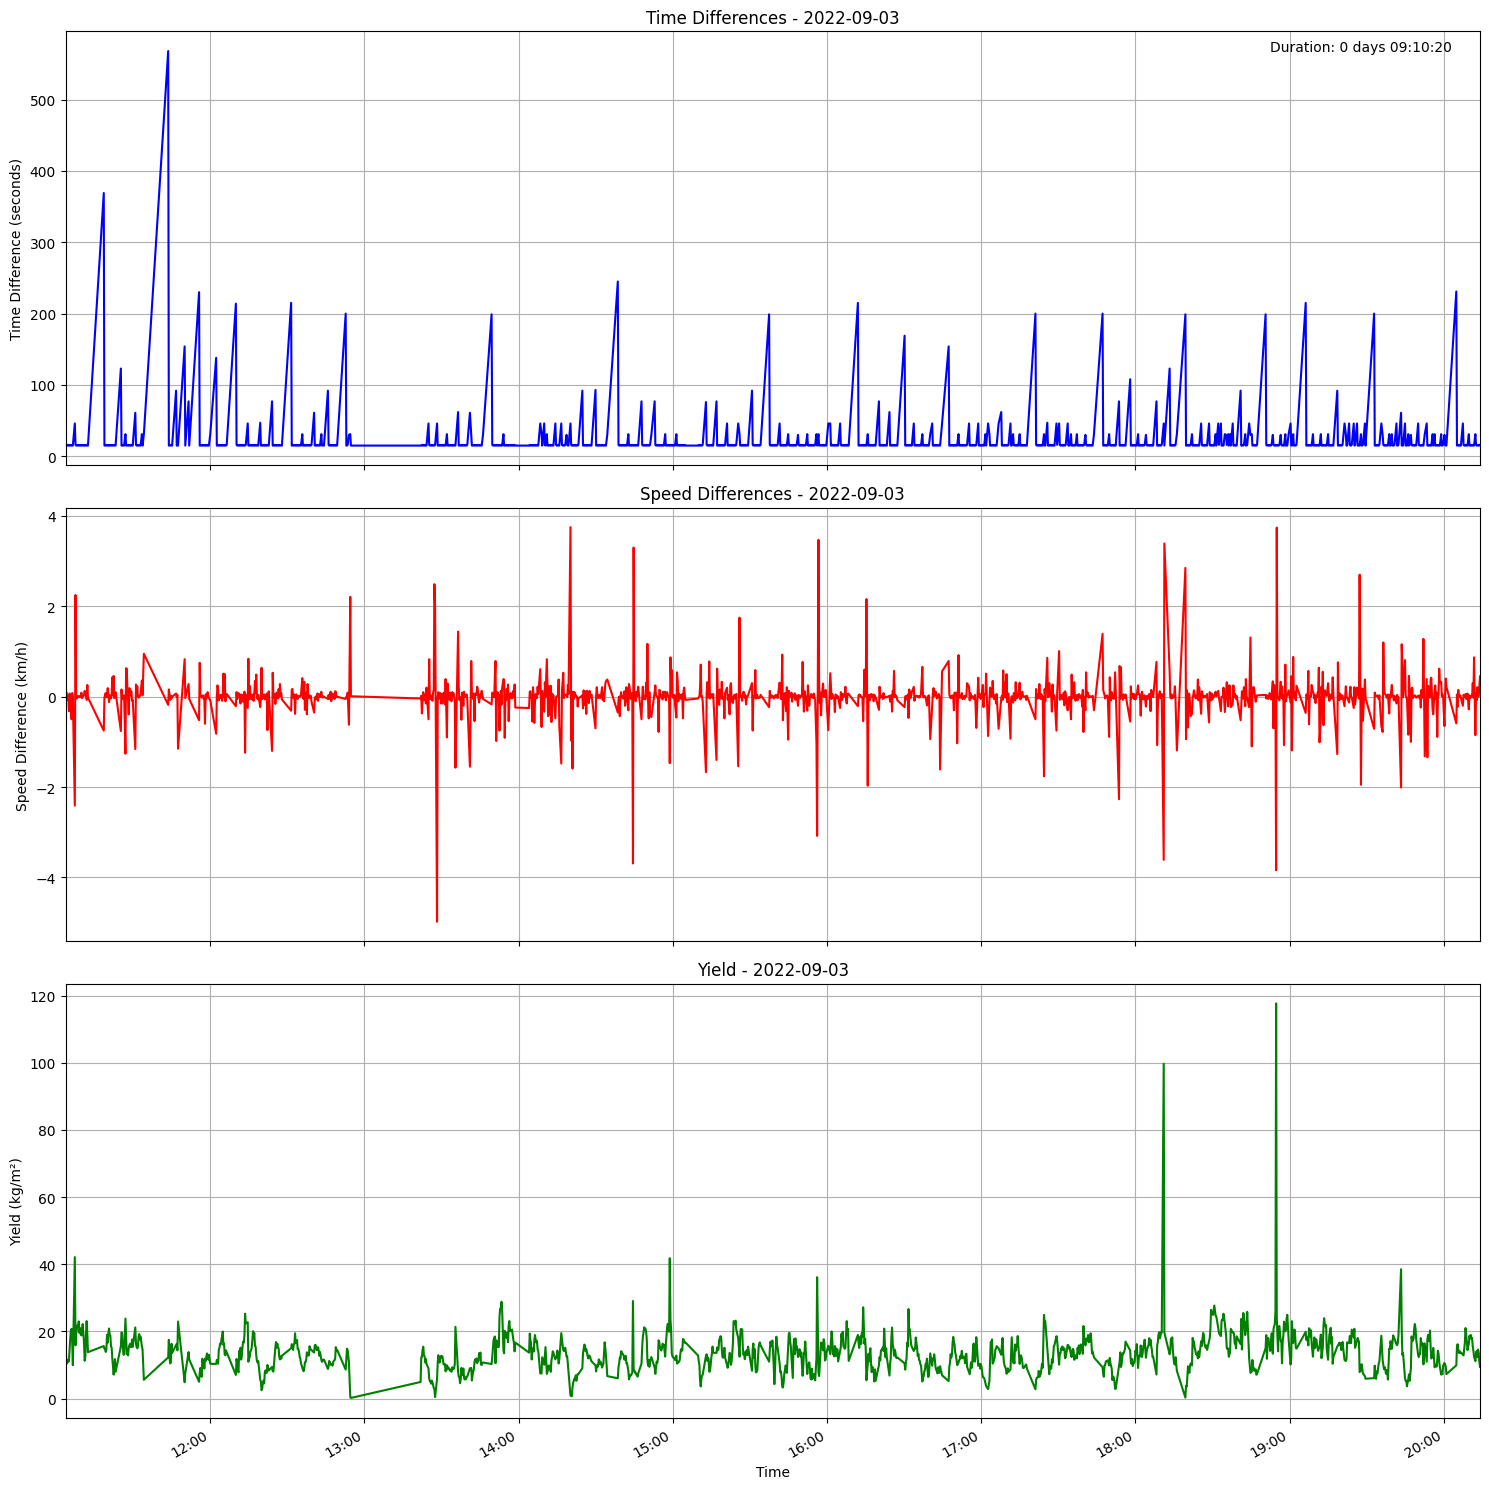

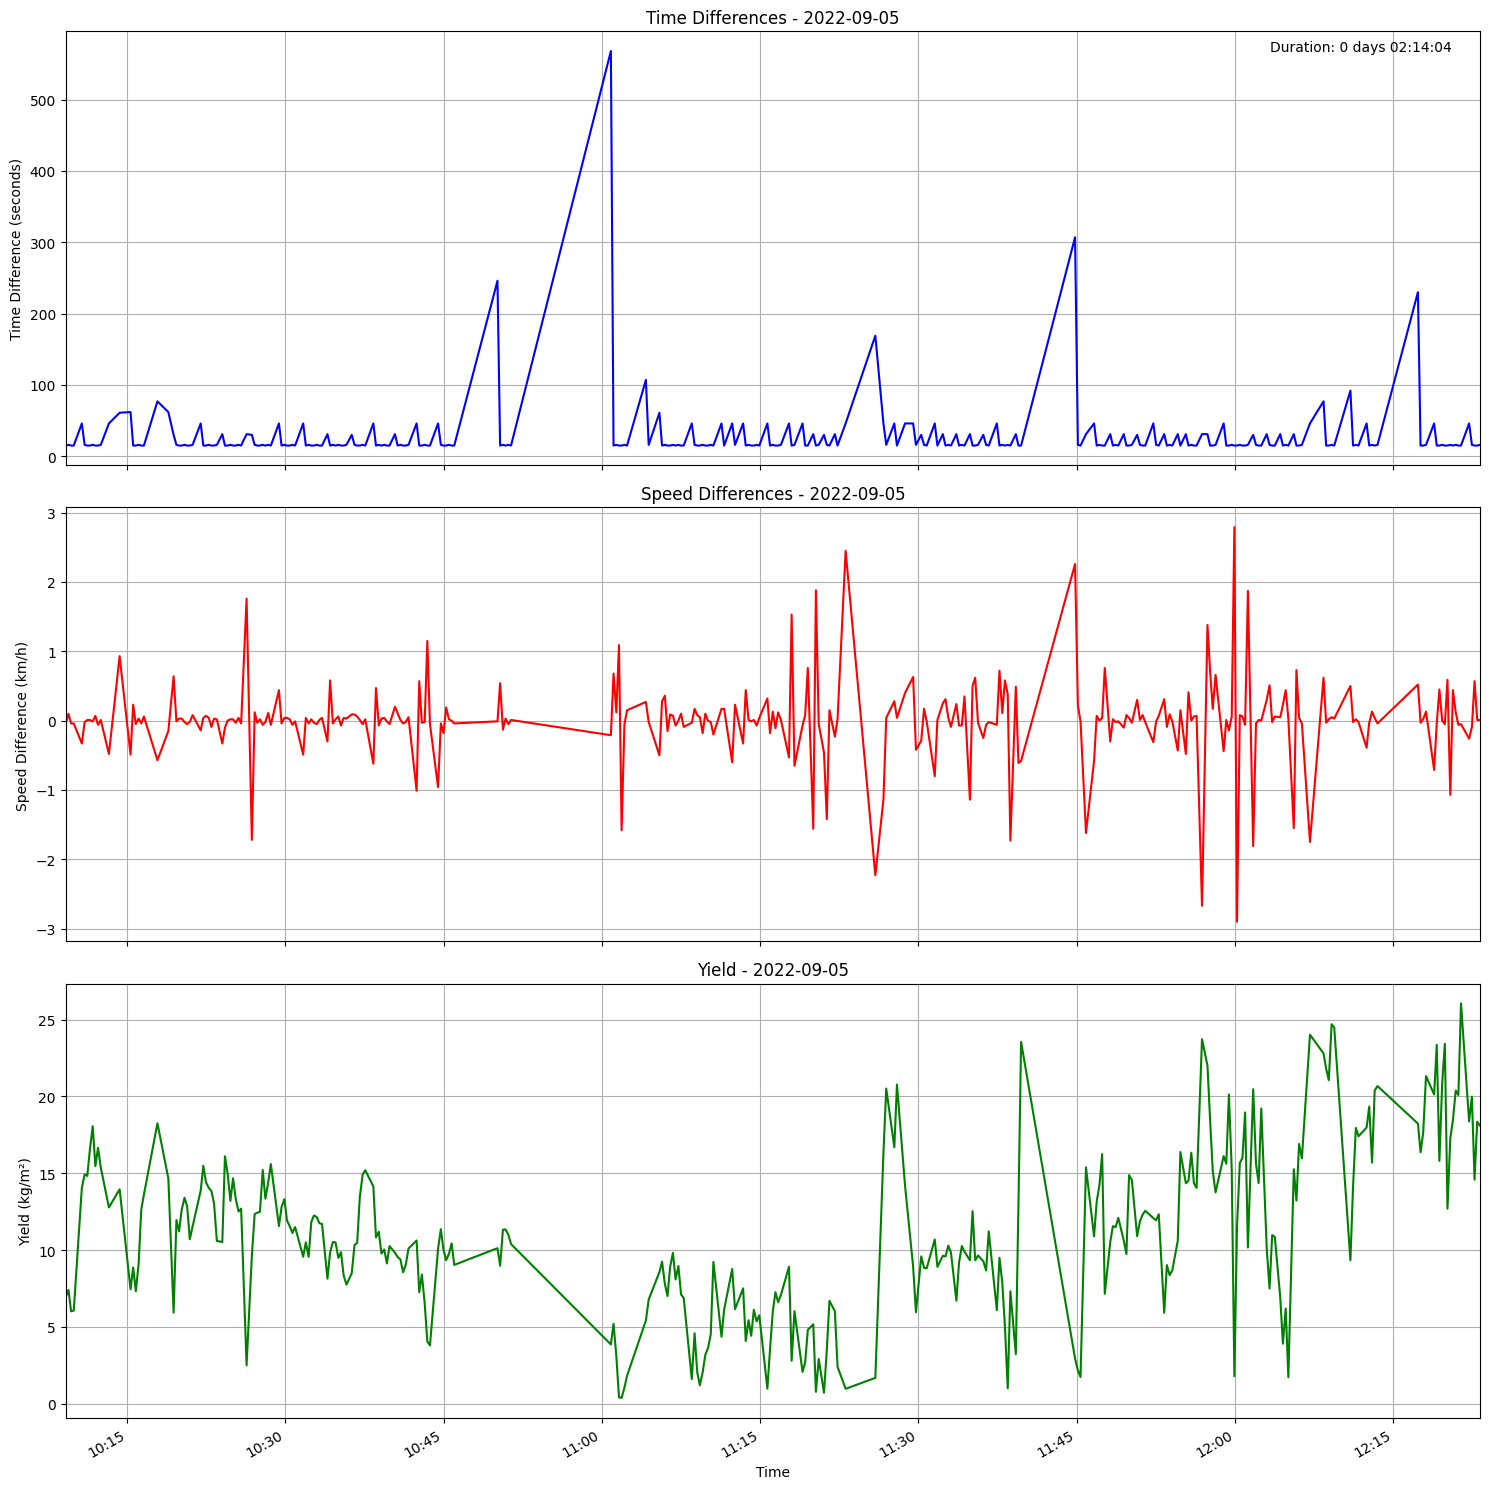

In [41]:
import matplotlib.dates as mdates

# Group the data by date
grouped = gdf.groupby(gdf['Data/Ora'].dt.date)

# Create a plot for each day
for date, group in grouped:
    # Skip the first row of each day to avoid potential outliers
    group = group.iloc[1:]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    
    # Plot Time Differences
    ax1.plot(group['Data/Ora'], group['Time_Diff'], 'b-')
    ax1.set_ylabel('Time Difference (seconds)')
    ax1.set_title(f'Time Differences - {date}')
    ax1.grid(True)
    
    # Plot Speed Differences
    ax2.plot(group['Data/Ora'], group['Speed_Diff'], 'r-')
    ax2.set_ylabel('Speed Difference (km/h)')
    ax2.set_title(f'Speed Differences - {date}')
    ax2.grid(True)
    
    # Plot Yield
    ax3.plot(group['Data/Ora'], group['Yield_kg_m2'], 'g-')
    ax3.set_ylabel('Yield (kg/m²)')
    ax3.set_xlabel('Time')
    ax3.set_title(f'Yield - {date}')
    ax3.grid(True)
    
    # Format x-axis to show time
    plt.gcf().autofmt_xdate()
    time_formatter = mdates.DateFormatter("%H:%M")
    ax3.xaxis.set_major_formatter(time_formatter)
    
    # Set x-axis limits to the actual working hours
    start_time = group['Data/Ora'].min()
    end_time = group['Data/Ora'].max()
    ax1.set_xlim(start_time, end_time)
    ax2.set_xlim(start_time, end_time)
    ax3.set_xlim(start_time, end_time)
    
    # Add text to show the duration of observations
    duration = end_time - start_time
    ax1.text(0.98, 0.98, f'Duration: {duration}', 
             transform=ax1.transAxes, ha='right', va='top')
    
    plt.tight_layout()
    plt.show()

Finally, these charts show us some important patterns: when the machine stops for some time, this can sometimes cause some variations in the yield calculation. What is more important is that the variation of the speed has a distinct oscillatory pattern and in particular we can see that sudden acceleration are immediately followed by deceleration (and / or vice versa). This causes some issues in the yield calculation and spikes that are not realistic.

We came to the conclusion that those sudden changes in the speed of the harvest machine are creating some artificial patterns in the yield data, hence they should be removed. 

In [61]:
# Define the threshold as km/h
threshold_high = 1.65       # These values were chosen subjectively after looking at the previous charts but are further from 3 std dev from the mean
threshold_low = -1.65

# Create a mask for valid speed differences
valid_speed_diff_mask = (gdf['Speed_Diff'] <= threshold_high) & (gdf['Speed_Diff'] >= threshold_low)

# Define the threshold as kg/m2
threshold_yield = 40       # These value was specifically chosen to remove any other explicit outlier not related to speed variation

# Create a mask for valid yield
valid_yield_mask = (gdf['Yield_kg_m2'] <= threshold_yield)

# Count the number of rows we are deleting
rows_to_delete = (~valid_speed_diff_mask).sum() + (~valid_yield_mask).sum()

# Apply the mask to filter the dataset
gdf_filtered = gdf[valid_speed_diff_mask & valid_yield_mask].copy()

# Reset the index of the filtered dataset
gdf_filtered.reset_index(drop=True, inplace=True)

# Print summary of the filtering process
print(f"Number of rows deleted: {rows_to_delete}")
print(f'Number of rows remaining: {len(gdf_filtered)}')

Number of rows deleted: 44
Number of rows remaining: 1906


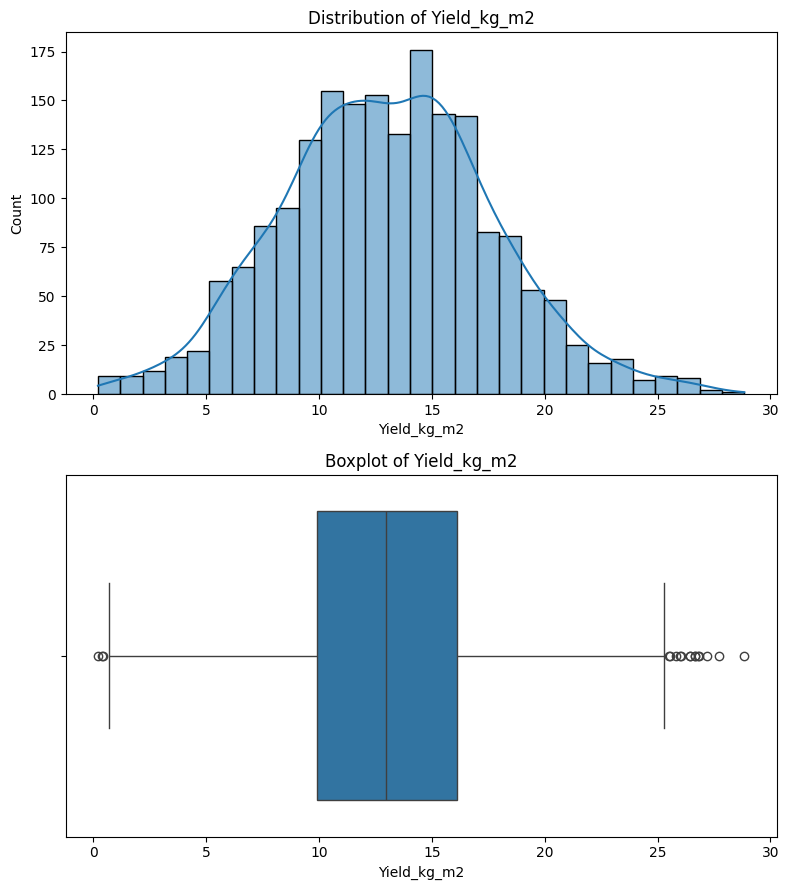

In [62]:
# Distribution plots and boxplots for specific numerical columns
specific_columns = ['Yield_kg_m2']
for column in specific_columns:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 9))
    
    # Histogram
    sns.histplot(gdf_filtered[column], kde=True, ax=ax1)
    ax1.set_title(f'Distribution of {column}')

    # Boxplot
    sns.boxplot(x=gdf_filtered[column], ax=ax2)
    ax2.set_title(f'Boxplot of {column}')
    
    plt.tight_layout()
    plt.show()

This distribution of the Yield_kg_m2 variable seems now more realistic and regular as we would expect it to be, also considering the initial variable 'RESAKG', which is the main variable we used to calculate the yield. We believe that the reason why Yield_kg_m2 was so problematic was due to the process of recalibration from RESAKG to Yield_kg_m2, amplified by the oscillatory pattern of the speed, and not to the RESAKG variable itself.

With a distribution of this type, we can assume stationarity for this variable, a property that will be important and the basis for models of yield mapping.

## Map Visualization

Let's now visualise the data we have built so far on a map.

Text(0.5, 1.0, 'Yield Distribution by Geographic Location\nDays: 2022-08-31, 2022-09-03, 2022-09-05')

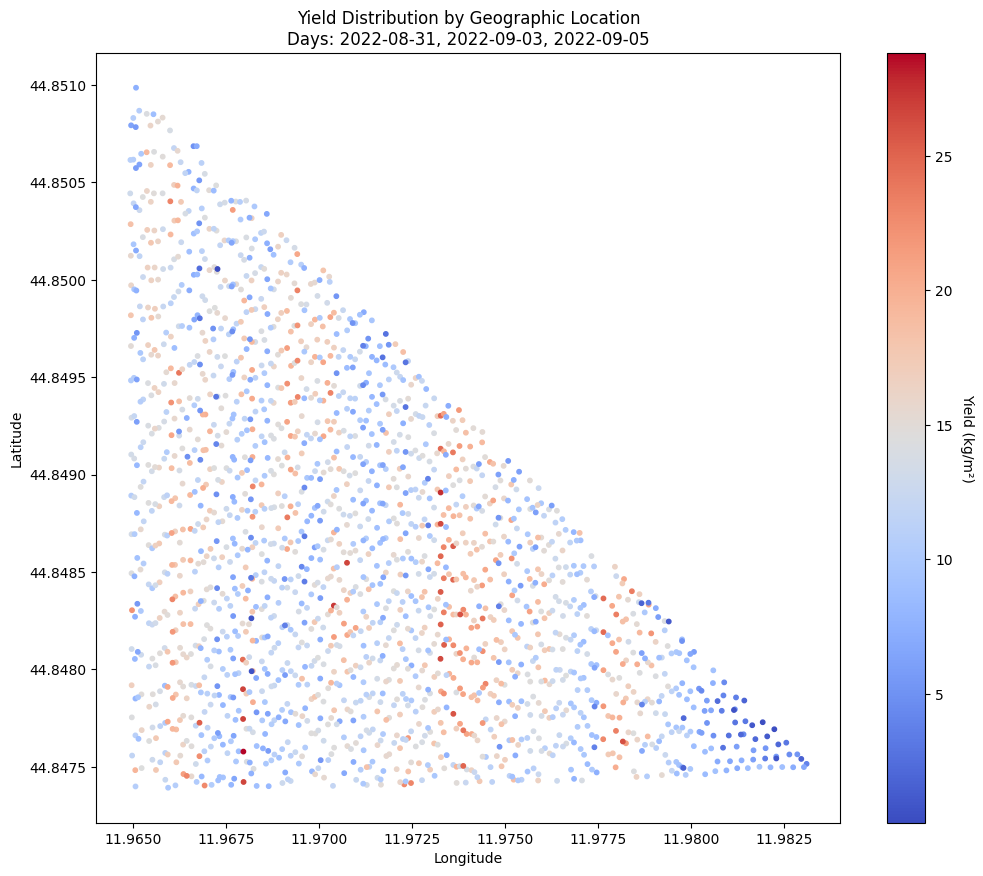

In [68]:
# Convert the string coordinates to float
gdf_filtered['Longitude'] = gdf_filtered['Longitudin'].str.replace(',', '.').astype(np.float64)
gdf_filtered['Latitude'] = gdf_filtered['Latitudine'].str.replace(',', '.').astype(np.float64)

# Extract unique dates from the dataset
unique_dates = gdf_filtered['Data/Ora'].dt.date.unique()

# print(unique_dates)

# Create a list of days you want to show (you can modify this list as needed)
days_to_show = [unique_dates[0], unique_dates[1], unique_dates[2]]

# Create a mask for the selected days
day_mask = gdf_filtered['Data/Ora'].dt.date.isin(days_to_show)

# Create the scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(gdf_filtered.loc[day_mask, 'Longitude'], 
                      gdf_filtered.loc[day_mask, 'Latitude'], 
                      c=gdf_filtered.loc[day_mask, 'Yield_kg_m2'], 
                      s=10,  # Point size
                      cmap='coolwarm')  # Color map

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Yield (kg/m²)', rotation=270, labelpad=15)

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Yield Distribution by Geographic Location\nDays: {", ".join(map(str, days_to_show))}')